In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

217.127206087


In [47]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    #print mesh
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

11.9190199375


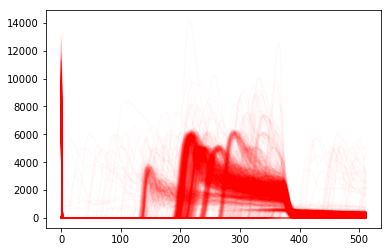

In [39]:
plt.plot(x.T.values,c=(1,0,0,0.02));

In [67]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

In [115]:
status_df = pd.read_csv("72_8_t0.csv")
status_df.columns = ['EventID','trigger']

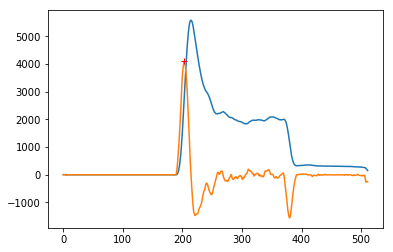

In [54]:
grad = np.gradient(convol_df.iloc[0].values)
peaks = peakdetect(grad,lookahead=10,delta=10)
pl = peaks[1]+peaks[0]
mp = max(np.abs(zip(*pl)[1]))
pl = [(x,y) for x,y in pl if abs(y)>0.08*mp and y>0]
plt.plot(convol_df.iloc[0].values*0.1)
plt.plot(grad)
plt.plot(zip(*pl)[0],zip(*pl)[1],'+',c='r')

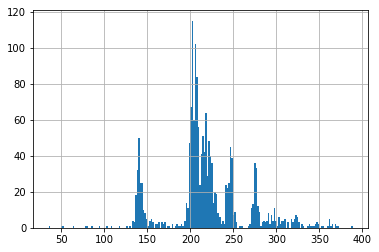

In [121]:
def FindLeadingEdge(event):
    grad = np.gradient(event.values)
    peaks = peakdetect(grad,lookahead=10,delta=10)
    pl = peaks[1]+peaks[0]
    pl = [(x,y) for x,y in pl if x>10 and x<500]
    mp = max(zip(*pl)[1])
    pl = [(x,y) for x,y in pl if abs(y)>0.5*mp]
    pp = sorted(pl,key=lambda x:x[1])[-1]
    return pd.Series(pp,index=['pos','height'])

    
tmp_df = pd.merge(convol_df,status_df,on='EventID')
tmp_df = tmp_df[~tmp_df['trigger'].isnull()]
tmp_df = tmp_df[tmp_df['trigger']<425]
peakdf = tmp_df.iloc[:,1:-1].apply(FindLeadingEdge,axis=1)
peakdf['pos'].hist(bins=200)

In [111]:
status_df.ix[1226]

EventID    1226.0
trigger     381.0
Name: 1226, dtype: float64